## 理解Diffusers模型的退化过程

In [1]:
# 导入torch全家桶
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler,UNet2DModel # 导入DDPM调度器和UNet跳跃连接模型
from matplotlib import pyplot as plt
import pytorch_lightning as pl

In [2]:
# 配置计算设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Input shape: torch.Size([8, 1, 28, 28]) label shape: torch.Size([8])


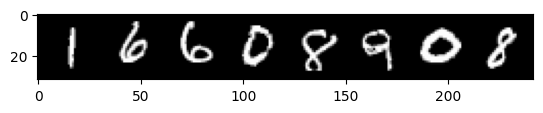

In [3]:
# 加载MNIST数据集
dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    transform=torchvision.transforms.ToTensor(), # 转换为张量
    download=True
)
# 构建数据加载器
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
# 获取X，y的可迭代对象
X, y = next(iter(data_loader))
# 打印X，y的形状
print("Input shape:", X.shape, "label shape:", y.shape)
# 使用torchvision的make_grid函数将X转换为图像
plt.imshow(torchvision.utils.make_grid(X)[0], cmap='gray')

In [4]:
# 创造噪声
def corrupt(x,amount):
    # 生成均值为0，方差为1的正态分布噪声
    noise = torch.randn_like(x)
    # 整理amount的形状，防止广播机制出错
    amount = amount.view(-1,1,1,1)
    # 生成噪声
    noise = amount * noise
    # 添加噪声
    return x*(1-amount) + noise

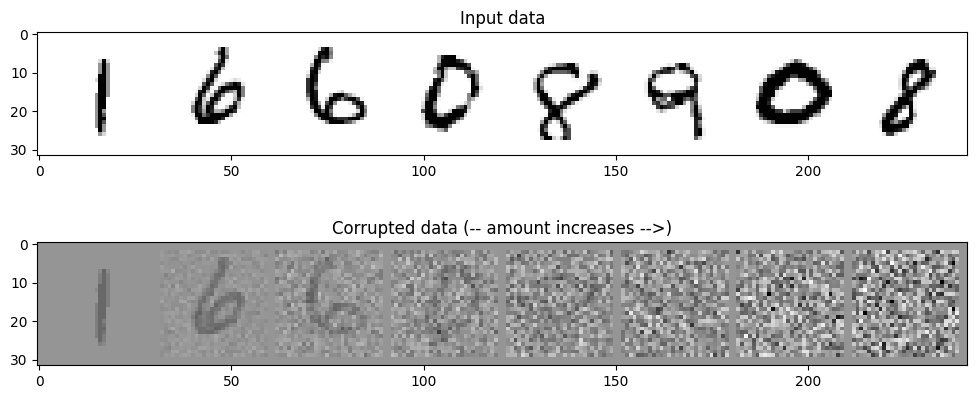

In [5]:
# 绘制输入数据
fig,axs = plt.subplots(2,1,figsize=(12,5))
axs[0].set_title('Input data')
axs[0].imshow(
    torchvision.utils.make_grid(X)[0],
    cmap='Greys'
)

# 加入噪声
amount = torch.linspace(0,1,X.shape[0]) # 当使用0-1的噪声分布时，退化效果将会更加强烈
noised_x = corrupt(X,amount)

# 绘制加入噪声后的数据
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(
    torchvision.utils.make_grid(noised_x)[0],
    cmap='Greys'
)

In [6]:
# 创建UNet基本模型
class BasicUNet(pl.LightningModule):
    def __init__(
        self,
        in_channels = 1,
        out_channels = 1
    ):
        super().__init__()
        # 下采样层
        self.down_layers = nn.ModuleList([
            nn.Conv2d(
                in_channels,32,kernel_size=5,padding=2 # 创建一个32滤波器，大小为5x5，填充为2的卷积层
            ),
            nn.Conv2d(
                32,64,kernel_size=5,padding=2
            ),
            nn.Conv2d(
                64,64,kernel_size=5,padding=2
            )
        ])
        # 上采样层
        self.up_layers = nn.ModuleList([
            nn.Conv2d(
                64,64,kernel_size=5,padding=2
            ),
            nn.Conv2d(
                64,32,kernel_size=5,padding=2
            ),
            nn.Conv2d(
                32,out_channels,kernel_size=5,padding=2
            )
        ])
        # 激活函数
        self.activation = nn.Sigmoid()
        # 池化层
        self.pool = nn.MaxPool2d(2)
        # 上采样
        self.upsample = nn.Upsample(scale_factor=2)
    def forward(self,x):
        h = []
        for i,l in enumerate(self.down_layers):
            x = self.activation(l(x)) # 通过运算层和激活函数
            if i < 2: # 选择除了第三层（最后一层）以外的层
                h.append(x) # 排列供残差连接使用
                x = self.pool(x) # 池化
        for i,l in enumerate(self.up_layers):
            if i > 0: # 选择除了第一层（第一层没有上采样）以外的层
                x = self.upsample(x) # 上采样
                x += h.pop() # 得到之前排列好的供残差连接使用的数据 
            x = self.activation(l(x)) # 通过运算层与激活函数
        return x # 返回输出

In [13]:
# 创建一个PyTorch Lightning模型
from typing import Any


class UNetModel(pl.LightningModule):
    def __init__(self,net):
        super().__init__()
        self.net = net
    def training_step(self,batch,batch_idx):
        x,y = batch
        x = x.view(-1,1,28,28)
        # 创建一个绑定噪声
        amount = torch.rand(x.shape[0],device=x.device)
        noised_x = corrupt(x,amount)
        # 获得神经网络输出
        output = self.net(noised_x)
        # 计算损失
        loss = F.mse_loss(output,x)
        # 记录损失
        self.log('train_loss',loss)
        return loss
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.net.parameters(),lr=1e-3)

In [14]:
# 设置超参数
batch_size = 128

In [15]:
# 划分数据集
train_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [16]:
# 设置max_epochs
max_epochs = 3
# 创建Pytorch Lightning模型
model = UNetModel(BasicUNet())
# 创建Pytorch Lightning训练器
trainer = pl.Trainer(
    max_epochs=max_epochs,
)
# 训练模型
trainer.fit(model,train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params
-----------------------------------
0 | net  | BasicUNet | 309 K 
-----------------------------------
309 K     Trainable params
0         Non-trainable params
309 K     Total params
1.236     Total estimated model params size (MB)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [17]:
# 可视化模型在”带噪“输入上的表现
# 得到一些数据

In [18]:
x,y = next(iter(train_dataloader))
x = x[:8]

# 在（0,1）区间选择退化
amount = torch.linspace(0,1,x.shape[0])
noised_x = corrupt(x,amount)

In [19]:
# 得到模型的预测结果
with torch.no_grad():
    pred = model.net(noised_x)
    pred = pred.detach().cpu()

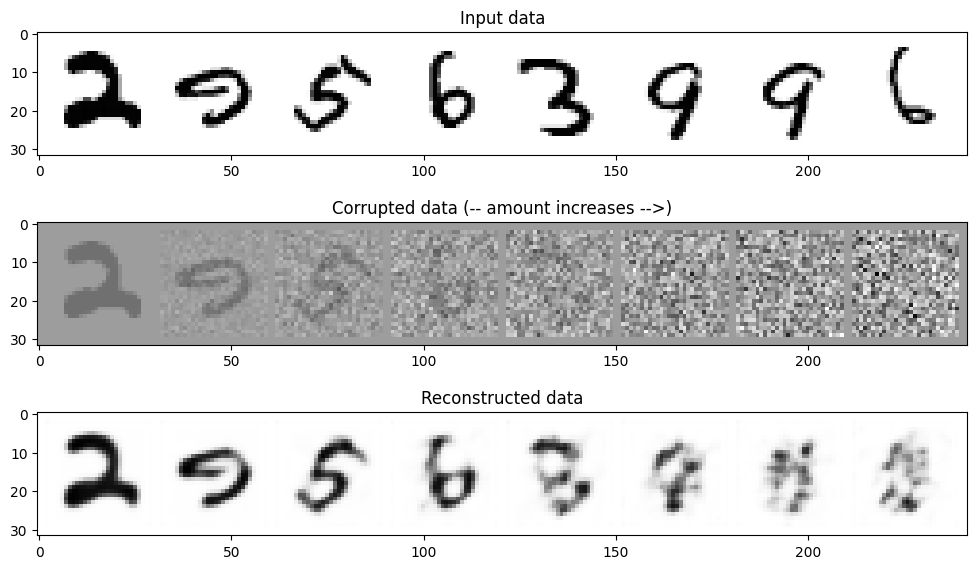

In [21]:
# 绘图
fig,axs = plt.subplots(3,1,figsize=(12,7))
axs[0].set_title('Input data')
axs[0].imshow(
    torchvision.utils.make_grid(x)[0],
    cmap='Greys'
)
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(
    torchvision.utils.make_grid(noised_x)[0],
    cmap='Greys'
)
axs[2].set_title('Reconstructed data')
axs[2].imshow(
    torchvision.utils.make_grid(pred)[0],
    cmap='Greys'
)

In [24]:
# 利用步幅移动实现高质量图像输出
n_steps = 5
x = torch.rand(5,1,28,28,device='cpu')
step_history = []
pred_output_history = []


In [25]:
for i in range(n_steps):
    with torch.no_grad(): # 禁用梯度计算
        pred = model.net(x) # 得到预测结果
    pred_output_history.append(pred.detach().cpu()) # 记录预测结果   
    
    mix_factor = 1 / (n_steps - i) # 设置朝着预测方向移动步幅
    x = x * (1 - mix_factor) + pred * mix_factor # 朝着预测方向移动
    step_history.append(x.detach().cpu()) # 记录移动后的结果

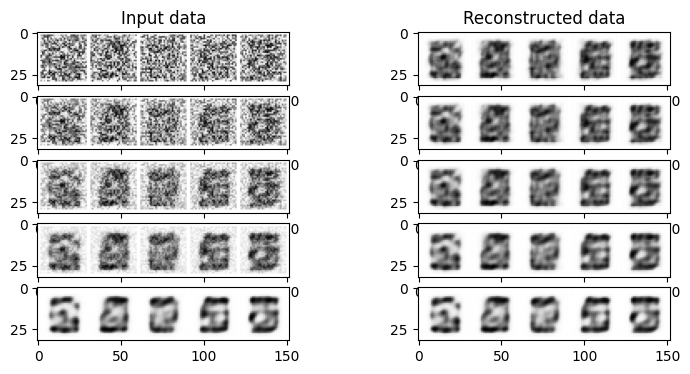

In [29]:
fig , axs = plt.subplots(n_steps,2,figsize=(9,4))
axs[0,0].set_title('Input data')
axs[0,1].set_title('Reconstructed data')
for i in range(n_steps):
    axs[i,0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0,1),
        cmap='Greys'
    )
    axs[i,1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1),
        cmap='Greys'
    )